In [56]:
import os
import collections 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Parameter
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.transforms import RandomNodeSplit
from torch import Tensor
from torch_geometric.nn import MessagePassing, SAGEConv, GCNConv
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import networkx as nx

from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [9]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

In [8]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [9]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


In [10]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  
print(f'Has self-loops: {data.has_self_loops()}')  
print(f'Is undirected: {data.is_undirected()}')  

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

In [14]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Average node degree: 3.90


,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


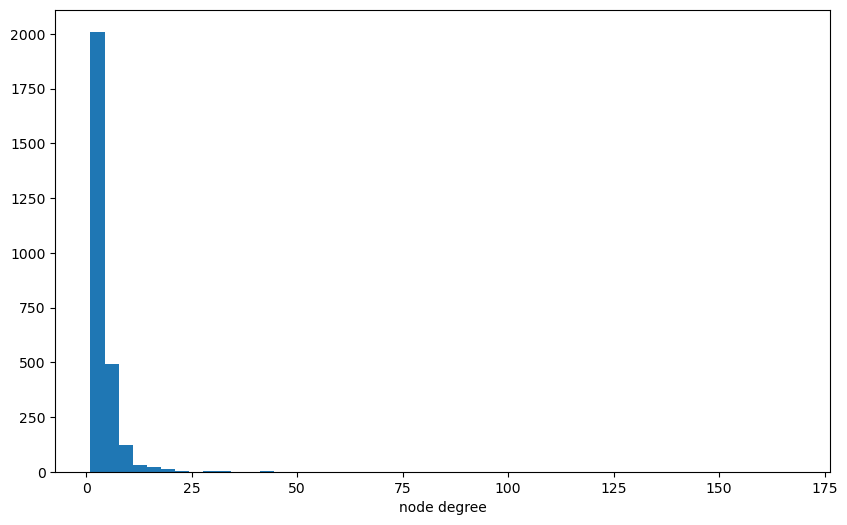

In [15]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

threshold 0.011821204285186553


/opt/anaconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


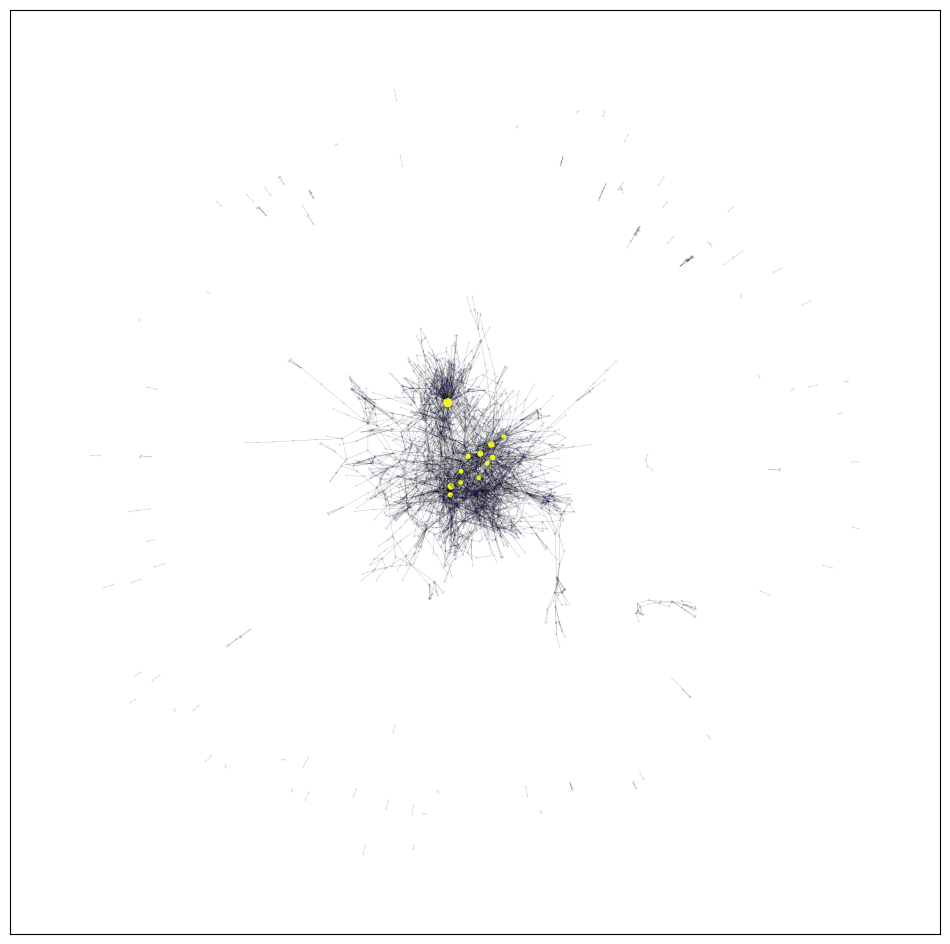

In [16]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)

cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))

cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)

edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [17]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1433


In [18]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

In [19]:
print(f'Number of edge features: {data.num_edge_features}')

Number of edge features: 0


In [20]:
print(f'Number of classes: {dataset.num_classes}')

Number of classes: 7


In [21]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


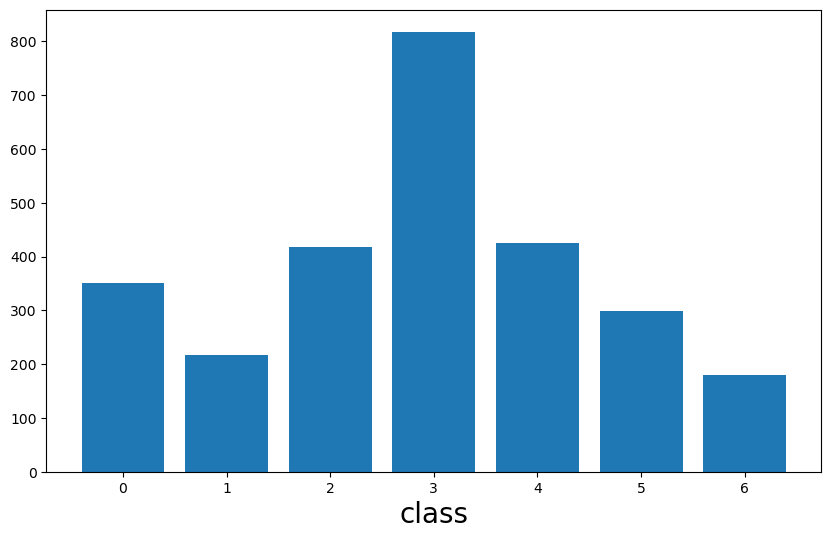

In [22]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)

count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

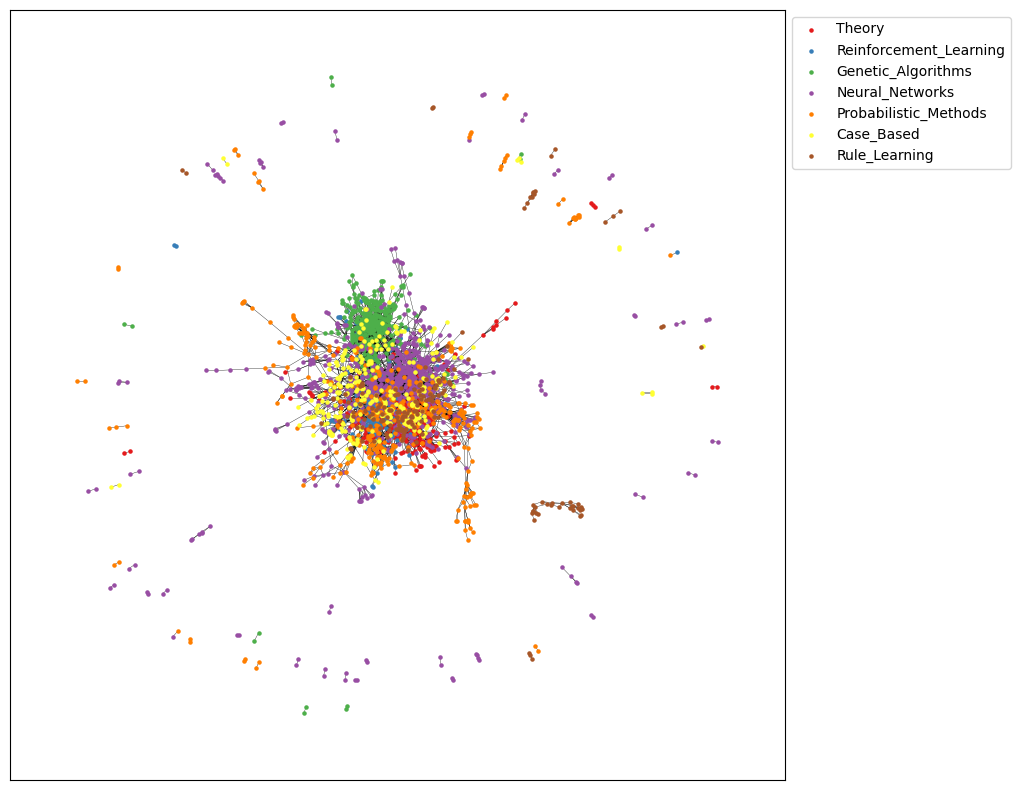

In [23]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]

colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
             '#ff7f00', '#ffff33', '#a65628']

labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

pos = nx.spring_layout(G, seed = 42)

plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())

for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, 
                           node_color = colorlist[num], label=l)

nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

---
**Homophily**

Nodes with the same characteristics are often connected. This property is called *homophily*. For the seven classes we looked at earlier, we will see how many nodes of the same class are connected by edges and vice versa.

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


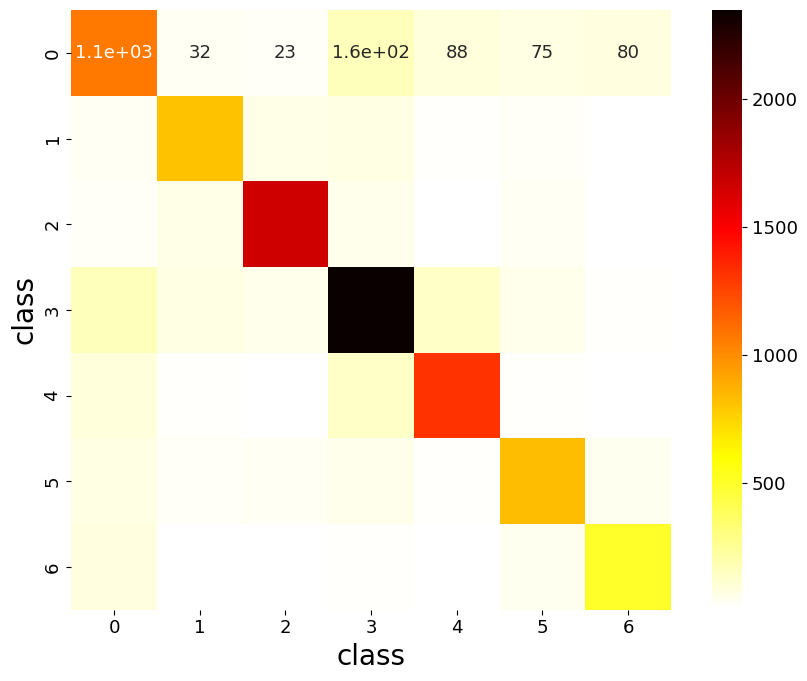

In [25]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter

label_connection_counts = []

for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)

label_connection_counts = np.array(label_connection_counts)

plt.figure(figsize=(9, 7))

plt.rcParams["font.size"] = 13

hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)

plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()

plt.show()

We can see that there are a great many nodes that are connected to each other belonging to the same class.

By dividing the sum of the diagonal components of the matrix by the sum of all components, we calculate the percentage of edges connected within the same class.

In [26]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()

0.8099658961727927

81% of the edges are connected within the same class.

In [28]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


# Training

## Vanilla GNN

### Our data preprocessing

The preprocessing code prepares the CORA dataset for use in a GNN. It loads the data from two files: one containing node features and labels, and the other representing the citation network (edges). The labels are encoded into integers, and node IDs are mapped to unique integer indices. Invalid edges are removed, and the node features are extracted, converted to numeric values, and normalized using sparse matrix formats for efficiency. The feature matrix is then normalized, and both the node features and labels are converted into PyTorch tensors. The dataset is split into training and testing sets using binary masks. Finally, the processed data is stored in a PyTorch Geometric Data object, which contains the node features, edge indices, labels, and train/test masks, making it ready for GNN training.

#### Default hyperparameters for **Vanilla GNN**
- `hidden_chanels` = 16
- `VanillaGNNLayer` = 2 layers
-  `activation` = `relu`
-  `dropout` = 1 layer with default settings
- `optimizer` = `Adam`
- `lr`= 0.01
- `weight_decay` = 5e-4
- `epochs` = 200

#### Metrics
**Training Loss**:
- `train_losses`: The loss is computed using negative **log-likelihood** loss (`F.nll_loss`) on the model's predictions for the training nodes.

**Test Accuracy**:
- `test_accuracies`: The accuracy is computed by comparing the predicted labels (`out.argmax(dim=1)`) with the true labels (`data.y`) for the nodes in the test set, determined by `data.test_mask`.
- **F1 Score** = $ 2 \times \frac{Precision \times Recall}{ Precision + Recall} $
- `confusion_matrix`: Shows the number of correct and incorrect predictions made by a classification model

Epoch: 001, Loss: 2.1860, Accuracy: 0.3372
Epoch: 002, Loss: 1.5830, Accuracy: 0.4358
Epoch: 003, Loss: 1.4742, Accuracy: 0.4740
Epoch: 004, Loss: 1.2855, Accuracy: 0.5015
Epoch: 005, Loss: 1.2803, Accuracy: 0.5099
Epoch: 006, Loss: 1.2638, Accuracy: 0.5359
Epoch: 007, Loss: 1.2122, Accuracy: 0.5398
Epoch: 008, Loss: 1.1397, Accuracy: 0.5864
Epoch: 009, Loss: 1.1518, Accuracy: 0.5902
Epoch: 010, Loss: 1.0726, Accuracy: 0.6009
Epoch: 011, Loss: 1.0786, Accuracy: 0.6078
Epoch: 012, Loss: 1.0646, Accuracy: 0.6078
Epoch: 013, Loss: 1.0275, Accuracy: 0.6109
Epoch: 014, Loss: 1.0224, Accuracy: 0.6063
Epoch: 015, Loss: 0.9890, Accuracy: 0.6093
Epoch: 016, Loss: 0.9599, Accuracy: 0.6093
Epoch: 017, Loss: 0.9921, Accuracy: 0.6101
Epoch: 018, Loss: 0.9744, Accuracy: 0.6109
Epoch: 019, Loss: 0.9744, Accuracy: 0.6063
Epoch: 020, Loss: 0.9717, Accuracy: 0.6093
Epoch: 021, Loss: 0.9475, Accuracy: 0.6093
Epoch: 022, Loss: 0.9907, Accuracy: 0.6109
Epoch: 023, Loss: 0.9242, Accuracy: 0.6109
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

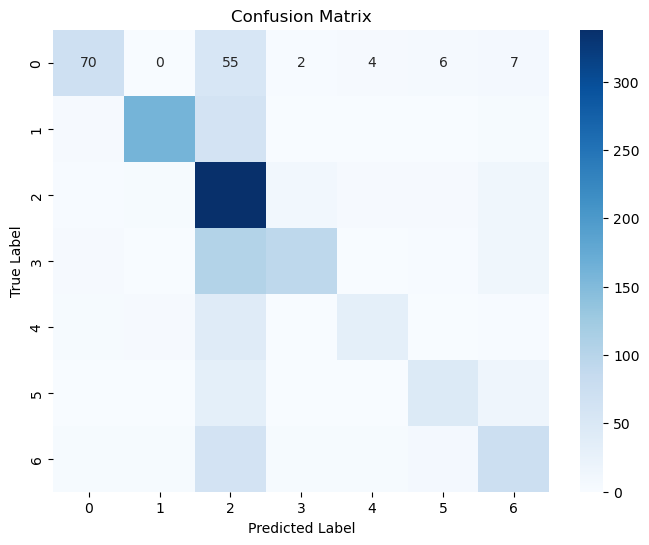

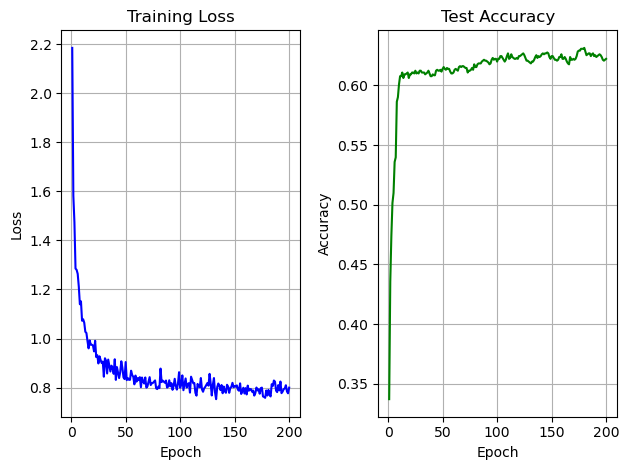

In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch_geometric.utils as utils
import torch.optim as optim
from torch_geometric.nn import GCNConv
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Load CORA data
cora_df = pd.read_csv(r'cora/cora.content', header=None, sep='\t')
cora_cites = pd.read_csv(r'cora/cora.cites', header=None, sep='\t')

# Labels
labels = cora_df.iloc[:, -1].values
le = LabelEncoder()
labels_y = le.fit_transform(labels)

# Map node IDs to integer indices
node_ids = cora_df.iloc[:, 0].values
id_map = {node_id: i for i, node_id in enumerate(node_ids)}

# Replace node IDs with integer indices, handling missing values
cora_df[0] = cora_df[0].apply(lambda x: id_map.get(x, -1))  # -1 as default for missing values
cora_cites[0] = cora_cites[0].map(id_map)
cora_cites[1] = cora_cites[1].map(id_map)

# Drop rows with missing values in edge list
cora_cites.dropna(inplace=True)

# Features (drop the first column as it's the node ID)
features_df = cora_df.iloc[:, 1:-1]

# Ensure all values are numeric
features_df = features_df.apply(pd.to_numeric, errors='coerce')

# Handle missing values (e.g., fill with 0)
features_df.fillna(0, inplace=True)

# Convert features to a sparse matrix
features = csr_matrix(features_df.values)

# Normalize the feature matrix (optional, but often helpful for GNNs)
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
features = scaler.fit_transform(features.toarray())
features = csr_matrix(features)  # Convert back to sparse if needed

# Convert features to a torch tensor
node_features = torch.tensor(features.toarray(), dtype=torch.float)

# Edge indices
edge_index = torch.tensor(cora_cites.values.T, dtype=torch.long)

# Labels
labels = torch.tensor(labels_y, dtype=torch.long)

# Train/Test mask
num_nodes = len(node_features)
train_mask = torch.tensor([True] * 1400 + [False] * (num_nodes - 1400))  # 1400 training, rest test
test_mask = torch.tensor([False] * 1400 + [True] * (num_nodes - 1400))

# Create Data object for PyTorch Geometric
data = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


class VanillaGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(VanillaGNNLayer, self).__init__(aggr='add')  # Aggregation method: 'add', 'mean', 'max', etc.
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Start the message passing process
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # The message function: simply passes the node features
        return x_j

    def update(self, aggr_out):
        # The update function: apply a linear transformation to aggregated messages
        return self.lin(aggr_out)

# Define the Vanilla GNN Model with 2 layers
class VanillaGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(VanillaGNN, self).__init__()
        # First layer: input -> hidden
        self.layer1 = VanillaGNNLayer(data.num_features, hidden_channels)
        # Second layer: hidden -> output (number of classes)
        self.layer2 = VanillaGNNLayer(hidden_channels, len(le.classes_))

    def forward(self, x, edge_index):
        # First layer with ReLU activation
        x = F.relu(self.layer1(x, edge_index))
        # Dropout layer for regularization
        x = F.dropout(x, training=self.training)
        # Second layer (no activation needed as we are doing classification)
        x = self.layer2(x, edge_index)
        # Apply log_softmax for multi-class classification
        return F.log_softmax(x, dim=1)

# Device setup (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VanillaGNN(hidden_channels=16).to(device)
data = data.to(device)  # Move the data to the device

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()  # Set the model to evaluation mode
    out = model(data.x, data.edge_index)  # Get model predictions
    pred = out.argmax(dim=1)  # Predicted class labels
    true_labels = data.y[data.test_mask]  # True labels for test nodes
    pred_labels = pred[data.test_mask]  # Predicted labels for test nodes
    
    # Calculate accuracy
    acc = (pred_labels == true_labels).sum().item() / true_labels.size(0)
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())  # Now works with import
    
    # Compute F1 score for each class (macro average and weighted average)
    f1_macro = f1_score(true_labels.cpu(), pred_labels.cpu(), average='macro')
    f1_weighted = f1_score(true_labels.cpu(), pred_labels.cpu(), average='weighted')
    
    return acc, cm, f1_macro, f1_weighted

# Function to plot confusion matrix using seaborn
def plot_confusion_matrix(cm):
    # Set up class names (use class names from the label encoder, or class indices)
    class_names = [str(i) for i in range(len(le.classes_))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Training loop with loss and accuracy tracking
train_losses = []
test_accuracies = []

# Training for 200 epochs
for epoch in range(1, 201):
    # Training phase
    loss = train()  # Train the model on the training set
    train_losses.append(loss)  # Store training loss for later plotting
    
    # Testing phase
    acc = test()[0]  # Only store accuracy (confusion matrix and F1 score are not needed here)
    test_accuracies.append(acc)  # Store accuracy for each epoch
    
    # Print loss and accuracy for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curve after training
epochs = range(1, 201)
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()  # Get the final test accuracy, confusion matrix, and F1 score
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

plt.figure(figsize=(12, 6))
plot_confusion_matrix(final_cm)
# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()




#### Hyperparameter \#1
using `StepLR` from `PyTorch`, which decays the learning rate by a factor every few epochs. This can help the model converge better by reducing the learning rate during training, preventing overshooting of the optimal point and stabilizing the learning process.

Epoch: 001, Loss: 1.0431, Accuracy: 0.5604, LR: 0.010000
Epoch: 002, Loss: 1.0859, Accuracy: 0.5573, LR: 0.010000
Epoch: 003, Loss: 1.0668, Accuracy: 0.5581, LR: 0.010000
Epoch: 004, Loss: 1.0657, Accuracy: 0.5581, LR: 0.010000
Epoch: 005, Loss: 1.0358, Accuracy: 0.5581, LR: 0.010000
Epoch: 006, Loss: 1.0727, Accuracy: 0.5596, LR: 0.010000
Epoch: 007, Loss: 1.0731, Accuracy: 0.5589, LR: 0.010000
Epoch: 008, Loss: 1.0427, Accuracy: 0.5596, LR: 0.010000
Epoch: 009, Loss: 1.0596, Accuracy: 0.5596, LR: 0.010000
Epoch: 010, Loss: 1.0809, Accuracy: 0.5612, LR: 0.010000
Epoch: 011, Loss: 1.0342, Accuracy: 0.5612, LR: 0.010000
Epoch: 012, Loss: 1.0550, Accuracy: 0.5604, LR: 0.010000
Epoch: 013, Loss: 1.0110, Accuracy: 0.5604, LR: 0.010000
Epoch: 014, Loss: 1.0402, Accuracy: 0.5612, LR: 0.010000
Epoch: 015, Loss: 1.0280, Accuracy: 0.5596, LR: 0.010000
Epoch: 016, Loss: 1.0537, Accuracy: 0.5604, LR: 0.010000
Epoch: 017, Loss: 1.0264, Accuracy: 0.5604, LR: 0.010000
Epoch: 018, Loss: 1.0197, Accur

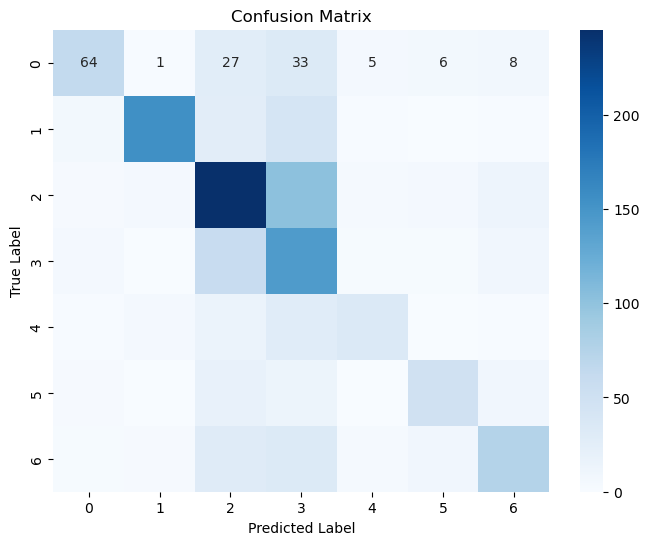

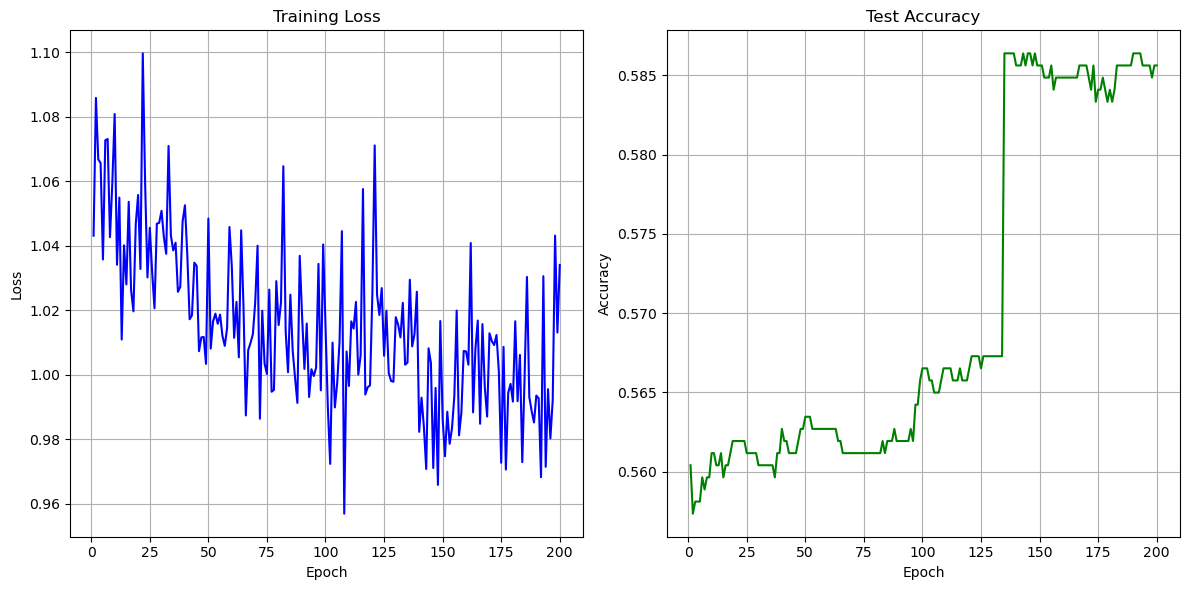

In [57]:
from torch.optim.lr_scheduler import StepLR

# Set up the learning rate scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Function to calculate test accuracy, confusion matrix, and F1 score
def test():
    model.eval()  # Set the model to evaluation mode
    out = model(data.x, data.edge_index)  # Get model predictions
    pred = out.argmax(dim=1)  # Predicted class labels
    true_labels = data.y[data.test_mask]  # True labels for test nodes
    pred_labels = pred[data.test_mask]  # Predicted labels for test nodes
    
    # Calculate accuracy
    acc = (pred_labels == true_labels).sum().item() / true_labels.size(0)
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())
    
    # Compute F1 score for each class (macro average and weighted average)
    f1_macro = f1_score(true_labels.cpu(), pred_labels.cpu(), average='macro')
    f1_weighted = f1_score(true_labels.cpu(), pred_labels.cpu(), average='weighted')
    
    return acc, cm, f1_macro, f1_weighted

# Function to plot confusion matrix using seaborn
def plot_confusion_matrix(cm):
    # Set up class names (use class names from the label encoder, or class indices)
    class_names = [str(i) for i in range(len(le.classes_))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Training loop with loss and accuracy tracking
for epoch in range(1, 201):
    # Training phase
    loss = train()  # Train the model on the training set
    train_losses.append(loss)  # Store training loss for later plotting
    
    # Step the scheduler to adjust the learning rate
    scheduler.step()
    
    # Testing phase
    acc = test()[0]  # Only store accuracy (confusion matrix and F1 score are not needed here)
    test_accuracies.append(acc)  # Store accuracy for each epoch
    
    # Print loss, accuracy, and learning rate for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Plotting the learning curve after training
epochs = range(1, 201)

# Final Test Accuracy, Confusion Matrix, and F1 Score
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()  # Get the final test accuracy, confusion matrix, and F1 score
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

# Plot confusion matrix only at the end of training
plot_confusion_matrix(final_cm)

plt.figure(figsize=(12, 6))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()




#### Hyperparamter \#2
An **Optimizer** can significantly impact a model's performance by influencing training speed, stability, and generalization.

Epoch: 001, Loss: 2.2115, Accuracy: 0.1330
Epoch: 002, Loss: 1.9718, Accuracy: 0.1881
Epoch: 003, Loss: 1.8706, Accuracy: 0.2110
Epoch: 004, Loss: 1.8543, Accuracy: 0.2332
Epoch: 005, Loss: 1.8216, Accuracy: 0.2492
Epoch: 006, Loss: 1.7873, Accuracy: 0.2645
Epoch: 007, Loss: 1.7460, Accuracy: 0.2745
Epoch: 008, Loss: 1.6942, Accuracy: 0.2882
Epoch: 009, Loss: 1.6782, Accuracy: 0.2959
Epoch: 010, Loss: 1.6583, Accuracy: 0.3555
Epoch: 011, Loss: 1.6279, Accuracy: 0.3616
Epoch: 012, Loss: 1.6585, Accuracy: 0.3968
Epoch: 013, Loss: 1.6147, Accuracy: 0.4190
Epoch: 014, Loss: 1.6034, Accuracy: 0.4266
Epoch: 015, Loss: 1.6037, Accuracy: 0.4312
Epoch: 016, Loss: 1.5559, Accuracy: 0.4320
Epoch: 017, Loss: 1.5591, Accuracy: 0.4358
Epoch: 018, Loss: 1.5409, Accuracy: 0.4419
Epoch: 019, Loss: 1.5422, Accuracy: 0.4495
Epoch: 020, Loss: 1.5287, Accuracy: 0.4602
Epoch: 021, Loss: 1.5448, Accuracy: 0.4664
Epoch: 022, Loss: 1.5407, Accuracy: 0.4702
Epoch: 023, Loss: 1.4495, Accuracy: 0.4763
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

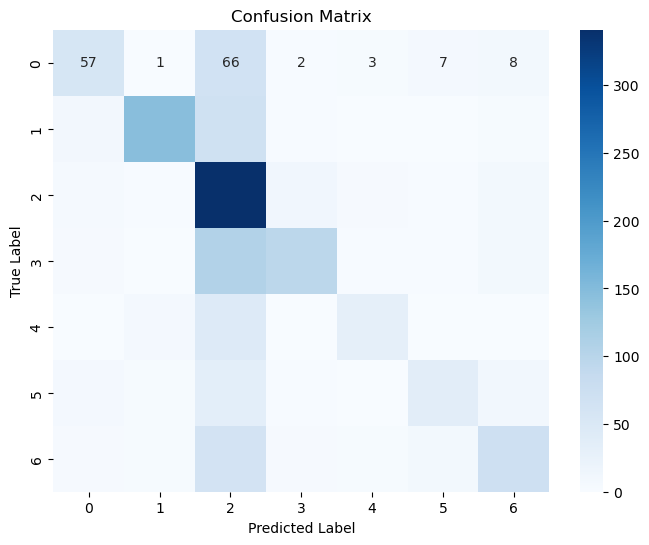

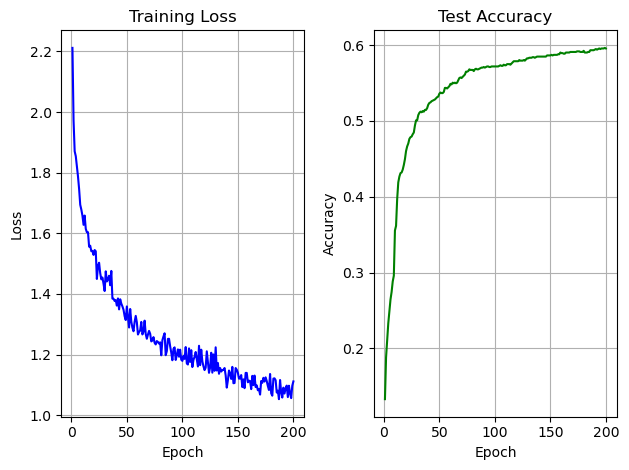

In [58]:
model = VanillaGNN(hidden_channels=16).to(device)

# Using SGD as the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training for 200 epochs
for epoch in range(1, 201):
    # Training phase
    loss = train()  # Train the model on the training set
    train_losses.append(loss)  # Store training loss for later plotting
    
    # Testing phase
    acc = test()[0]  # Only store accuracy (confusion matrix and F1 score are not needed here)
    test_accuracies.append(acc)  # Store accuracy for each epoch
    
    # Print loss and accuracy for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curve after training
epochs = range(1, 201)
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()  # Get the final test accuracy, confusion matrix, and F1 score
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

plt.figure(figsize=(12, 6))
plot_confusion_matrix(final_cm)
# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()



#### Hyperparameter \#3
`Dropout` is a regularization technique that helps prevent overfitting by randomly setting some of the activations to zero during training. Adjusting the dropout rate allows the model to generalize better, especially when the dataset is small or noisy.

Epoch: 001, Loss: 2.1394, Accuracy: 0.4381
Epoch: 002, Loss: 1.4342, Accuracy: 0.4801
Epoch: 003, Loss: 1.2271, Accuracy: 0.5031
Epoch: 004, Loss: 1.1106, Accuracy: 0.5191
Epoch: 005, Loss: 1.1204, Accuracy: 0.5321
Epoch: 006, Loss: 1.0820, Accuracy: 0.5405
Epoch: 007, Loss: 1.0724, Accuracy: 0.5451
Epoch: 008, Loss: 1.0156, Accuracy: 0.5803
Epoch: 009, Loss: 1.0003, Accuracy: 0.5749
Epoch: 010, Loss: 0.9212, Accuracy: 0.6246
Epoch: 011, Loss: 0.9469, Accuracy: 0.6254
Epoch: 012, Loss: 0.9452, Accuracy: 0.6261
Epoch: 013, Loss: 0.9002, Accuracy: 0.6261
Epoch: 014, Loss: 0.8861, Accuracy: 0.6300
Epoch: 015, Loss: 0.8515, Accuracy: 0.6284
Epoch: 016, Loss: 0.8287, Accuracy: 0.6269
Epoch: 017, Loss: 0.8210, Accuracy: 0.6254
Epoch: 018, Loss: 0.8309, Accuracy: 0.6239
Epoch: 019, Loss: 0.8651, Accuracy: 0.6269
Epoch: 020, Loss: 0.8542, Accuracy: 0.6261
Epoch: 021, Loss: 0.8058, Accuracy: 0.6223
Epoch: 022, Loss: 0.8294, Accuracy: 0.6200
Epoch: 023, Loss: 0.8052, Accuracy: 0.6200
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

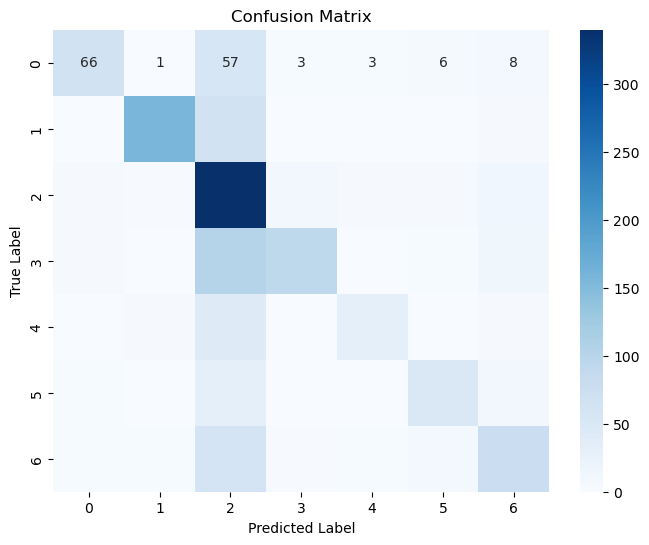

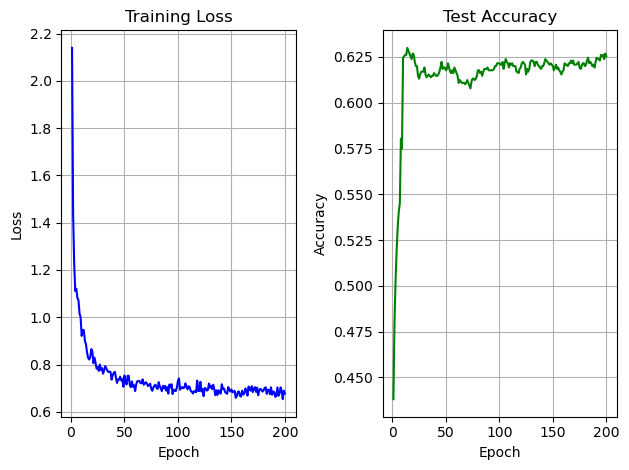

In [59]:
# Experimenting with different dropout rates
dropout_rate = 0.7  # Trying values like 0.2, 0.3, 0.5, and 0.7

class VanillaGNN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate):
        super(VanillaGNN, self).__init__()
        self.layer1 = VanillaGNNLayer(data.num_features, hidden_channels)
        self.layer2 = VanillaGNNLayer(hidden_channels, len(le.classes_))
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = F.relu(self.layer1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Apply dropout
        x = self.layer2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model setup
model = VanillaGNN(hidden_channels=16, dropout_rate=0.3).to(device)  # Experiment with different dropout rates


data = data.to(device)  


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training for 200 epochs
for epoch in range(1, 201):
    # Training phase
    loss = train()  # Train the model on the training set
    train_losses.append(loss)  # Store training loss for later plotting
    
    # Testing phase
    acc = test()[0]  # Only store accuracy (confusion matrix and F1 score are not needed here)
    test_accuracies.append(acc)  # Store accuracy for each epoch
    
    # Print loss and accuracy for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curve after training
epochs = range(1, 201)
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()  # Get the final test accuracy, confusion matrix, and F1 score
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

plt.figure(figsize=(12, 6))
plot_confusion_matrix(final_cm)
# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()




## GraphSAGE


#### Our default hyperparameters for **GraphSAGE**
- `hidden_chanels` = 16
- `SAGEConv` = 2 layers
-  `activation` = `relu`
-  `dropout` (`p` = 0.5)
- `optimizer` = `Adam`
- `lr`= 0.01
- `weight_decay` = 5e-4
- `epochs` = 200

Epoch: 001, Loss: 2.0445, Accuracy: 0.4794
Epoch: 002, Loss: 1.4920, Accuracy: 0.5604
Epoch: 003, Loss: 1.1378, Accuracy: 0.6162
Epoch: 004, Loss: 0.9287, Accuracy: 0.6521
Epoch: 005, Loss: 0.7575, Accuracy: 0.6865
Epoch: 006, Loss: 0.6201, Accuracy: 0.7026
Epoch: 007, Loss: 0.5208, Accuracy: 0.7209
Epoch: 008, Loss: 0.4597, Accuracy: 0.7332
Epoch: 009, Loss: 0.3959, Accuracy: 0.7385
Epoch: 010, Loss: 0.3796, Accuracy: 0.7424
Epoch: 011, Loss: 0.3440, Accuracy: 0.7416
Epoch: 012, Loss: 0.3356, Accuracy: 0.7485
Epoch: 013, Loss: 0.2707, Accuracy: 0.7515
Epoch: 014, Loss: 0.2637, Accuracy: 0.7538
Epoch: 015, Loss: 0.2417, Accuracy: 0.7576
Epoch: 016, Loss: 0.2615, Accuracy: 0.7584
Epoch: 017, Loss: 0.2284, Accuracy: 0.7615
Epoch: 018, Loss: 0.2196, Accuracy: 0.7622
Epoch: 019, Loss: 0.2302, Accuracy: 0.7615
Epoch: 020, Loss: 0.2351, Accuracy: 0.7584
Epoch: 021, Loss: 0.1871, Accuracy: 0.7561
Epoch: 022, Loss: 0.1948, Accuracy: 0.7592
Epoch: 023, Loss: 0.1826, Accuracy: 0.7554
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

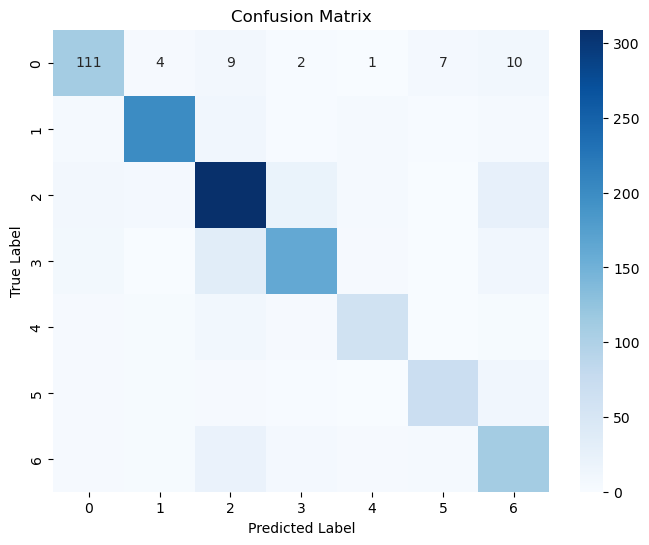

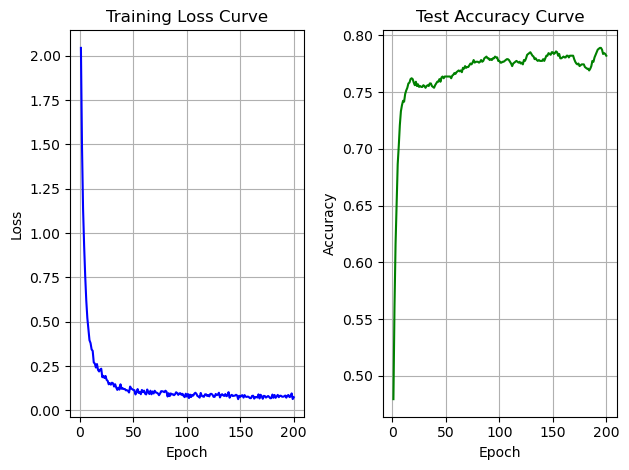

In [70]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Custom GraphSAGE model definition
class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(CustomGraphSAGE, self).__init__()
        # GraphSAGE convolution layers
        self.layer1 = SAGEConv(data.num_features, hidden_channels)
        self.layer2 = SAGEConv(hidden_channels, len(le.classes_))  # Number of classes

    def forward(self, feature_data, edge_info):
        # First GraphSAGE layer
        x = self.layer1(feature_data, edge_info)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GraphSAGE layer
        x = self.layer2(x, edge_info)
        
        return F.log_softmax(x, dim=1)

# Initialize the CustomGraphSAGE model
SAGE_model = CustomGraphSAGE(hidden_channels=16).to(device)

# Optimizer setup
optimizer = torch.optim.Adam(SAGE_model.parameters(), lr=0.01, weight_decay=5e-4)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training function
def train():
    SAGE_model.train()
    optimizer.zero_grad()
    out = SAGE_model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function that also computes F1 score and confusion matrix
def test():
    SAGE_model.eval()
    out = SAGE_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Predicted class labels
    true_labels = data.y[data.test_mask]  # True labels for test nodes
    pred_labels = pred[data.test_mask]  # Predicted labels for test nodes
    
    # Calculate accuracy
    acc = (pred_labels == true_labels).sum().item() / true_labels.size(0)
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())
    
    # Compute F1 score for each class (macro average and weighted average)
    f1_macro = f1_score(true_labels.cpu(), pred_labels.cpu(), average='macro')
    f1_weighted = f1_score(true_labels.cpu(), pred_labels.cpu(), average='weighted')
    
    return acc, cm, f1_macro, f1_weighted

# Function to plot confusion matrix using seaborn
def plot_confusion_matrix(cm):
    class_names = [str(i) for i in range(len(le.classes_))]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Training loop with loss, accuracy, F1 score, and confusion matrix tracking
for epoch in range(1, 201):
    # Training step
    loss = train()
    train_losses.append(loss)

    # Testing step
    acc, cm, f1_macro, f1_weighted = test()
    test_accuracies.append(acc)

    # Print loss, accuracy, F1 scores, and learning rate for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curves
epochs = range(1, 201)

plt.figure(figsize=(12, 6))

# Final test accuracy, F1 scores, and confusion matrix
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

# Plot confusion matrix only at the end of training
plot_confusion_matrix(final_cm)
# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()




#### Hyperparameter \#4
A good hyperparameter to adjust in the `GraphSAGE` model is the number of `hidden_channels` for the `SAGEConv` layers. This determines the dimensionality of the node representations after each `GraphSAGE` layer. A higher number of hidden channels might improve the model's capacity to learn more complex patterns but can also lead to overfitting if the model is too large for the data

Epoch: 001, Loss: 2.1277, Accuracy: 0.3723
Epoch: 002, Loss: 1.1636, Accuracy: 0.6865
Epoch: 003, Loss: 0.6247, Accuracy: 0.7263
Epoch: 004, Loss: 0.4511, Accuracy: 0.7446
Epoch: 005, Loss: 0.3181, Accuracy: 0.7576
Epoch: 006, Loss: 0.2418, Accuracy: 0.7638
Epoch: 007, Loss: 0.2017, Accuracy: 0.7683
Epoch: 008, Loss: 0.1765, Accuracy: 0.7645
Epoch: 009, Loss: 0.1333, Accuracy: 0.7599
Epoch: 010, Loss: 0.1127, Accuracy: 0.7538
Epoch: 011, Loss: 0.0839, Accuracy: 0.7592
Epoch: 012, Loss: 0.0635, Accuracy: 0.7576
Epoch: 013, Loss: 0.0617, Accuracy: 0.7569
Epoch: 014, Loss: 0.0529, Accuracy: 0.7599
Epoch: 015, Loss: 0.0403, Accuracy: 0.7607
Epoch: 016, Loss: 0.0422, Accuracy: 0.7653
Epoch: 017, Loss: 0.0388, Accuracy: 0.7714
Epoch: 018, Loss: 0.0347, Accuracy: 0.7722
Epoch: 019, Loss: 0.0262, Accuracy: 0.7737
Epoch: 020, Loss: 0.0320, Accuracy: 0.7729
Epoch: 021, Loss: 0.0313, Accuracy: 0.7691
Epoch: 022, Loss: 0.0254, Accuracy: 0.7683
Epoch: 023, Loss: 0.0212, Accuracy: 0.7691
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

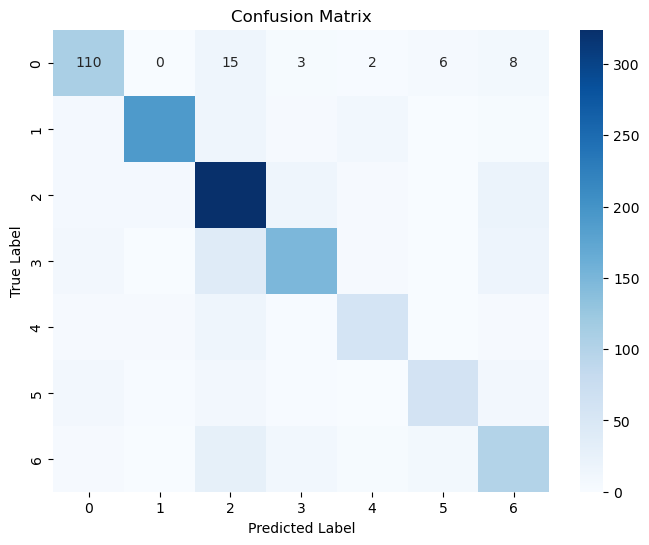

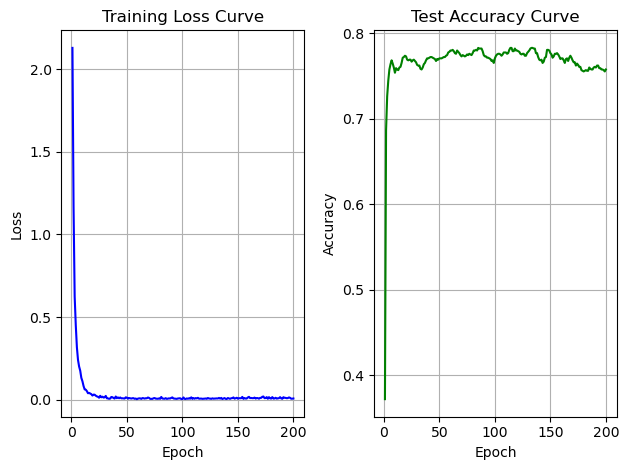

In [72]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv

class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels=32):  # Adding default hidden_channels=32
        super(CustomGraphSAGE, self).__init__()
        # GraphSAGE convolution layers
        self.layer1 = SAGEConv(data.num_features, hidden_channels)
        self.layer2 = SAGEConv(hidden_channels, len(le.classes_))  # Number of classes

    def forward(self, feature_data, edge_info):
        # First GraphSAGE layer
        x = self.layer1(feature_data, edge_info)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GraphSAGE layer
        x = self.layer2(x, edge_info)
        
        return F.log_softmax(x, dim=1)

# Initialize the CustomGraphSAGE model
SAGE_model = CustomGraphSAGE(hidden_channels=64).to(device)  # Experimenting with 64 hidden channels

# Optimizer setup
optimizer = torch.optim.Adam(SAGE_model.parameters(), lr=0.01, weight_decay=5e-4)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training function
def train():
    SAGE_model.train()
    optimizer.zero_grad()
    out = SAGE_model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function that also computes F1 score and confusion matrix
def test():
    SAGE_model.eval()
    out = SAGE_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Predicted class labels
    true_labels = data.y[data.test_mask]  # True labels for test nodes
    pred_labels = pred[data.test_mask]  # Predicted labels for test nodes
    
    # Calculate accuracy
    acc = (pred_labels == true_labels).sum().item() / true_labels.size(0)
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())
    
    # Compute F1 score for each class (macro average and weighted average)
    f1_macro = f1_score(true_labels.cpu(), pred_labels.cpu(), average='macro')
    f1_weighted = f1_score(true_labels.cpu(), pred_labels.cpu(), average='weighted')
    
    return acc, cm, f1_macro, f1_weighted

# Function to plot confusion matrix using seaborn
def plot_confusion_matrix(cm):
    class_names = [str(i) for i in range(len(le.classes_))]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Training loop with loss, accuracy, F1 score, and confusion matrix tracking
for epoch in range(1, 201):
    # Training step
    loss = train()
    train_losses.append(loss)

    # Testing step
    acc, _, _, _ = test()  # Only track accuracy during training
    test_accuracies.append(acc)

    # Print loss, accuracy, F1 scores, and learning rate for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curves
epochs = range(1, 201)

plt.figure(figsize=(12, 6))
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

# Plot confusion matrix only at the end of training
plot_confusion_matrix(final_cm)
# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


#### Hyperparamter \#5
Weight decay (also known as L2 regularization), this hyperparameter controls the amount of regularization applied to the model's weights to prevent overfitting. Weight decay adds a penalty to the loss function based on the magnitude of the weights, encouraging smaller weights and reducing the model's capacity to overfit the training data.

Epoch: 001, Loss: 2.1182, Accuracy: 0.4274
Epoch: 002, Loss: 1.4549, Accuracy: 0.5268
Epoch: 003, Loss: 1.1132, Accuracy: 0.6078
Epoch: 004, Loss: 0.8535, Accuracy: 0.6544
Epoch: 005, Loss: 0.7524, Accuracy: 0.6957
Epoch: 006, Loss: 0.6303, Accuracy: 0.7286
Epoch: 007, Loss: 0.5438, Accuracy: 0.7385
Epoch: 008, Loss: 0.5055, Accuracy: 0.7355
Epoch: 009, Loss: 0.4323, Accuracy: 0.7370
Epoch: 010, Loss: 0.4197, Accuracy: 0.7424
Epoch: 011, Loss: 0.3654, Accuracy: 0.7416
Epoch: 012, Loss: 0.3405, Accuracy: 0.7401
Epoch: 013, Loss: 0.3370, Accuracy: 0.7408
Epoch: 014, Loss: 0.3067, Accuracy: 0.7492
Epoch: 015, Loss: 0.2587, Accuracy: 0.7469
Epoch: 016, Loss: 0.2367, Accuracy: 0.7477
Epoch: 017, Loss: 0.2279, Accuracy: 0.7515
Epoch: 018, Loss: 0.2112, Accuracy: 0.7531
Epoch: 019, Loss: 0.1958, Accuracy: 0.7554
Epoch: 020, Loss: 0.1960, Accuracy: 0.7554
Epoch: 021, Loss: 0.1868, Accuracy: 0.7538
Epoch: 022, Loss: 0.1534, Accuracy: 0.7569
Epoch: 023, Loss: 0.1924, Accuracy: 0.7569
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

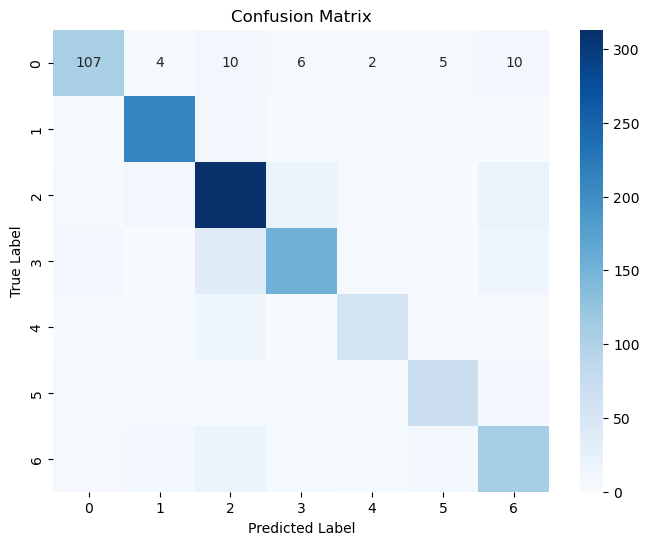

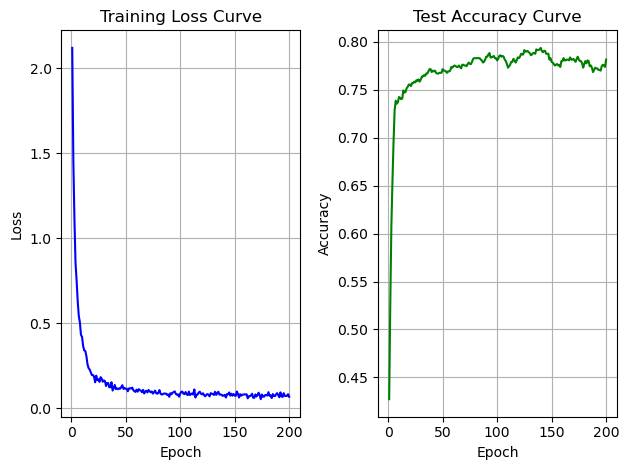

In [73]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Custom GraphSAGE model definition
class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(CustomGraphSAGE, self).__init__()
        # GraphSAGE convolution layers
        self.layer1 = SAGEConv(data.num_features, hidden_channels)
        self.layer2 = SAGEConv(hidden_channels, len(le.classes_))  # Number of classes

    def forward(self, feature_data, edge_info):
        # First GraphSAGE layer
        x = self.layer1(feature_data, edge_info)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GraphSAGE layer
        x = self.layer2(x, edge_info)
        
        return F.log_softmax(x, dim=1)

# Initialize the CustomGraphSAGE model
SAGE_model = CustomGraphSAGE(hidden_channels=16).to(device)

# Optimizer setup with a hyperparameter for weight decay
weight_decay = 1e-3  

optimizer = torch.optim.Adam(SAGE_model.parameters(), lr=0.01, weight_decay=weight_decay)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []


# Training loop with loss, accuracy, F1 score, and confusion matrix tracking
for epoch in range(1, 201):
    # Training step
    loss = train()
    train_losses.append(loss)

    # Testing step
    acc, cm, f1_macro, f1_weighted = test()
    test_accuracies.append(acc)

    # Print loss, accuracy, F1 scores, and learning rate for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curves
epochs = range(1, 201)

plt.figure(figsize=(12, 6))

# Final test accuracy, F1 scores, and confusion matrix
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

# Plot confusion matrix only at the end of training
plot_confusion_matrix(final_cm)
# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


#### Hyperparamter \#6
Another hyperparamter we can experiment with is the **activation function** after the convolution layers. Different activation functions can impact the model's performance.

Epoch: 001, Loss: 2.0255, Accuracy: 0.5069
Epoch: 002, Loss: 1.2957, Accuracy: 0.5581
Epoch: 003, Loss: 0.9332, Accuracy: 0.6284
Epoch: 004, Loss: 0.7696, Accuracy: 0.6758
Epoch: 005, Loss: 0.6276, Accuracy: 0.7225
Epoch: 006, Loss: 0.5527, Accuracy: 0.7332
Epoch: 007, Loss: 0.4716, Accuracy: 0.7454
Epoch: 008, Loss: 0.4046, Accuracy: 0.7477
Epoch: 009, Loss: 0.3879, Accuracy: 0.7584
Epoch: 010, Loss: 0.3216, Accuracy: 0.7615
Epoch: 011, Loss: 0.2831, Accuracy: 0.7592
Epoch: 012, Loss: 0.2666, Accuracy: 0.7630
Epoch: 013, Loss: 0.2795, Accuracy: 0.7630
Epoch: 014, Loss: 0.2631, Accuracy: 0.7622
Epoch: 015, Loss: 0.2488, Accuracy: 0.7645
Epoch: 016, Loss: 0.2056, Accuracy: 0.7622
Epoch: 017, Loss: 0.2218, Accuracy: 0.7638
Epoch: 018, Loss: 0.1995, Accuracy: 0.7607
Epoch: 019, Loss: 0.1824, Accuracy: 0.7645
Epoch: 020, Loss: 0.2035, Accuracy: 0.7638
Epoch: 021, Loss: 0.1699, Accuracy: 0.7615
Epoch: 022, Loss: 0.1532, Accuracy: 0.7630
Epoch: 023, Loss: 0.1586, Accuracy: 0.7653
Epoch: 024,

<Figure size 1200x600 with 0 Axes>

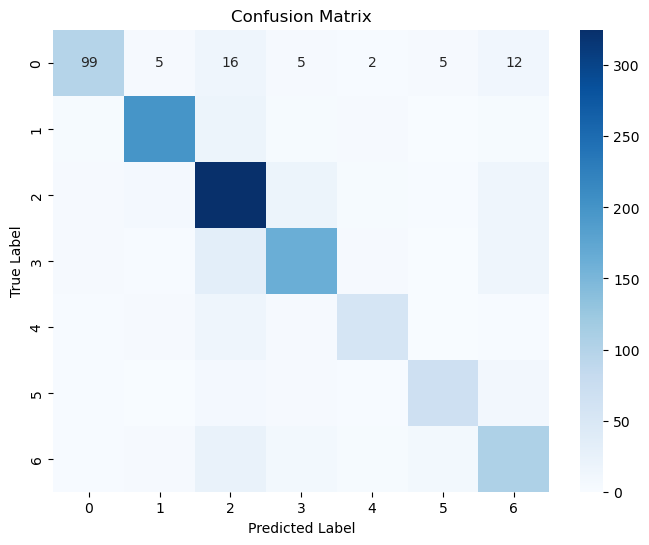

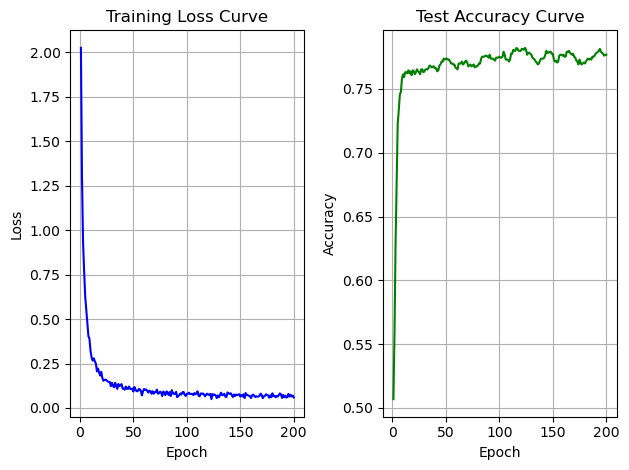

In [75]:
class CustomGraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, activation_function=F.relu):
        super(CustomGraphSAGE, self).__init__()
        # GraphSAGE convolution layers
        self.layer1 = SAGEConv(data.num_features, hidden_channels)
        self.layer2 = SAGEConv(hidden_channels, len(le.classes_))  # Number of classes
        self.activation_function = activation_function  # Store the activation function

    def forward(self, feature_data, edge_info):
        # First GraphSAGE layer
        x = self.layer1(feature_data, edge_info)
        x = self.activation_function(x)  # Apply the chosen activation function
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GraphSAGE layer
        x = self.layer2(x, edge_info)
        
        return F.log_softmax(x, dim=1)

# Initialize the CustomGraphSAGE model with LeakyReLU
SAGE_model = CustomGraphSAGE(hidden_channels=16, activation_function=F.leaky_relu).to(device)

# Optimizer setup
optimizer = torch.optim.Adam(SAGE_model.parameters(), lr=0.01, weight_decay=5e-4)

# Store loss and accuracy for plotting
train_losses = []
test_accuracies = []

# Training function
for epoch in range(1, 201):
    # Training step
    loss = train()
    train_losses.append(loss)

    # Testing step
    acc, cm, f1_macro, f1_weighted = test()
    test_accuracies.append(acc)

    # Print loss, accuracy, F1 scores, and learning rate for each epoch
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

# Plotting the learning curves
epochs = range(1, 201)

plt.figure(figsize=(12, 6))

# Final test accuracy, F1 scores, and confusion matrix
final_accuracy, final_cm, final_f1_macro, final_f1_weighted = test()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final F1 Macro Score: {final_f1_macro:.4f}')
print(f'Final F1 Weighted Score: {final_f1_weighted:.4f}')

# Plot confusion matrix only at the end of training
plot_confusion_matrix(final_cm)
# Plot the training loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot the test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()